<a href="https://colab.research.google.com/github/Joyatulya/colab_notebooks/blob/main/NIH_CXR_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

#Setting up the environment

In [ ]:
!git clone https://github.com/Joyatulya/utils.git

Cloning into 'utils'...
remote: Enumerating objects: 2031, done.
remote: Counting objects: 100% (2031/2031), done.
remote: Compressing objects: 100% (1745/1745), done.
remote: Total 2031 (delta 268), reused 1999 (delta 250), pack-reused 0
Receiving objects: 100% (2031/2031), 6.30 MiB | 12.40 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [ ]:
from utils.dataset_loader import 
# !kaggle datasets download -d nih-chest-xrays/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying kaggle.json


In [ ]:
!unzip ./drive/MyDrive/augmented_zip_images.zip -d ./

In [ ]:
!cp ./drive/MyDrive/predicted_full_nih.csv ./predicted_full_nih.csv
!cp ./drive/MyDrive/nih_dataset/predicted_full_nih.csv ./predicted_full_nih.csv
# !cp ./drive/MyDrive/masks_nih.zip ./masks_nih.zip
# !unzip masks_nih.zip

cp: cannot stat './drive/MyDrive/nih_dataset/predicted_full_nih.csv': No such file or directory


In [ ]:
!pip install -qq wandb

     |████████████████████████████████| 1.8 MB 13.0 MB/s 
     |████████████████████████████████| 145 kB 63.4 MB/s 
     |████████████████████████████████| 181 kB 66.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


#Importing Libraries
---



In [ ]:
!cp ./drive/MyDrive/worst_cxr.txt ./worst_cxr.txt
!cp ./drive/MyDrive/last_cxr.txt ./last_cxr.txt

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
import os
import shutil
import wandb

from google.colab import files
from glob import glob
from keras import layers

from utils import nn_helper
from utils import nn_advanced
%env WANDB_START_METHOD=thread
wandb.login()
SEED = 1996
tf.random.set_seed(SEED)

env: WANDB_START_METHOD=thread


wandb: Currently logged in as: joy_atulya. Use `wandb login --relogin` to force relogin


#HyperParameters
---

---



In [ ]:
AUX_DATA_COLUMNS = ['age', 'position','ct_ratio', 'ct_area', 'right_cp_angle', 'right_cp_angle_direction',
                    'left_cp_angle', 'left_cp_angle_direction', 'cp_rel_position',
                    'height_width_ratio', 'area_ratio', 'vertical_span_ratio', 'gender']

categorical_cols = ['gender', 'position']

numerical_cols = ['ct_ratio','ct_area','right_cp_angle','left_cp_angle','cp_rel_position','height_width_ratio','area_ratio','vertical_span_ratio']

PATHOLOGY_LIST = ['Cardiomegaly','Emphysema','Effusion','Pneumothorax','Atelectasis',
                  'Mass','Edema','Consolidation',]

INPUT_SHAPE = (384,384,3)

configs = dict(
    data_flag = 'nih_all',
    channels = 3,
    image_shape = INPUT_SHAPE,
    batch_size = 32,
    class_names = PATHOLOGY_LIST
)


#Utilities

In [ ]:
@tf.function
def process_img(img):
  _img = tf.io.read_file(img)
  _img = tf.image.decode_png(_img,channels = configs['channels'])
  _img = tf.image.resize(_img,configs['channels'][:2])
  # _img /= 255 # Just for the efficientNet we dont need this
  return _img

def read_img(img):
  _img = tf.io.read_file(img)
  _img = tf.image.decode_png(_img,channels = configs['channels'])
  return _img

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(PATHOLOGY_LIST[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

def change_dtype(x):
  if isinstance(x, str):
    return x
  return np.float32(x)

def show_img(path):
  plt.figure(figsize = (10,10))
  img = process_img(path)
  plt.imshow(img, cmap = 'gray')

def process_img(img):
  _img = tf.io.read_file(img)
  _img = tf.image.decode_png(_img,channels = configs['channels'])
  # _img = tf.image.resize(_img,IMG_SIZE[:2])
  # _img /= 255 # Just for the efficientNet we dont need this
  return _img[:,:,0]

def save_download_model(model, name):
  model.save(name)
  shutil.make_archive( name, 'zip', 'name')
  files.download(f'{name}.zip')


#Loading and Cleaning data
---

In [ ]:
raw_df = pd.read_csv('./Data_Entry_2017.csv')
raw_df = raw_df.drop('Unnamed: 11', axis = 1)
raw_df.columns = ['image_index','findings', 'f/u', 'pt_id',
                  'age', 'gender', 'position',
                  'Width','Height', 'x', 'y']

# all_image_paths = {os.path.basename(x): x for x in 
                  #  glob(os.path.join('.', 'images*', '*', '*.png'))}
                   
# print('Scans found:', len(all_image_paths), ', Total Headers', raw_df.shape[0])
# raw_df['path'] = raw_df['image_index'].map(all_image_paths.get)
raw_df['path'] = './augmented/' + raw_df['image_index']
raw_df['mask'] = './masks/' + raw_df['image_index'] + '_mask.png'

In [ ]:
raw_df

,image_index,findings,f/u,pt_id,age,gender,position,Width,Height,x,y,path,mask
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,./augmented/00000001_000.png,./masks/00000001_000.png_mask.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,./augmented/00000001_001.png,./masks/00000001_001.png_mask.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,./augmented/00000001_002.png,./masks/00000001_002.png_mask.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,./augmented/00000002_000.png,./masks/00000002_000.png_mask.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,./augmented/00000003_000.png,./masks/00000003_000.png_mask.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,./augmented/00030801_001.png,./masks/00030801_001.png_mask.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,./augmented/00030802_000.png,./masks/00030802_000.png_mask.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,./augmented/00030803_000.png,./masks/00030803_000.png_mask.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,./augmented/00030804_000.png,./masks/00030804_000.png_mask.png


In [ ]:
aux_df = pd.read_csv('./predicted_full_nih.csv')
aux_df = aux_df.iloc[:, 2:]
full_df = pd.merge(raw_df, aux_df, how = 'inner', on = 'image_index')

In [ ]:
# path_full = raw_df.path.values
# img_name_full = raw_df.image_index.values

# @tf.function
# def process_ds(img,):
#   _img = tf.io.read_file(img)
#   _img = tf.image.decode_png(_img,channels = configs['channels'])
#   _img = data_augmentation(_img, training = True)
#   return _img

# def df_to_ds(path, img_name):
#   df = tf.data.Dataset.from_tensor_slices((path, img_name))
#   df = df.cache()
#   df = df.map(lambda x, y : (process_ds(x), y), num_parallel_calls=-1, deterministic=True)
#   df = df.prefetch(tf.data.AUTOTUNE)
#   return df
# i = 0
# n = len(raw_df)
# print(n)
# print(list(range(0,n,20000)))
# checkpoints = list(range(0,n,20000)) + [n - 1]
# print(checkpoints)
# raw_df.iloc[checkpoints[-1],:]
# for path, img_name in zip(path_full, img_name_full):
# with wandb.init() as r:
#   for i, num in enumerate(checkpoints):
#     print(num)
#     slice_df = slice(num, checkpoints[i + 1])
#     ds = df_to_ds(path_full[slice_df], img_name_full[slice_df])
#     name = 'processed_' + str(num)
#     tf.data.experimental.save(ds, name, compression='GZIP')
#     artifact = wandb.Artifact('augment', type='dataset')
#     artifact.add_dir(f'./{name}', name)
#     wandb.log_artifact(artifact)
#     !rm -r ./{name}



# for img, name in df.as_numpy_iterator():
#   # print(name)
#   # plt.imshow(i[0])
#   path = './augmented_img/' + name.decode()
#   # print(path)
#   np.save(path,img )
#   break

# ds = df_to_ds(path_full, img_name_full)
# i = 0
# for image, name in ds.as_numpy_iterator():
#   pil = tf.keras.preprocessing.image.array_to_img(image, scale = True,)
#   pil.save(f'./augmented/{name.decode()}')
#   # print(type(pil))
#   if i % 1000 == 0 : print(i)
#   i += 1

112120


In [ ]:
working_df = full_df.copy()
working_df['findings'] = working_df['findings'].str.replace('Infiltration','Consolidation')
working_df['findings'] = working_df['findings'].str.replace('Pneumonia','Consolidation')
working_df['findings'] = working_df['findings'].str.replace('Nodule','Mass')

In [ ]:
with open('./worst_cxr.txt', 'r') as f:
  worst_cxr = f.read().split('\n')
worst_cxr = worst_cxr[:-1]
worst_cxr = set(worst_cxr)
worst_cxr = np.array([*worst_cxr])
worst_cxr = worst_cxr.astype('int')

with open('./last_cxr.txt', 'r') as f:
  last_cxr = f.read().split('\n')
last_cxr = last_cxr[:-1]
last_cxr = set(last_cxr)
last_cxr = np.array([*last_cxr])
last_cxr = last_cxr.astype('int')

In [ ]:
# For Patients whose all the images were bad
num = 0
for sick_pt_id in worst_cxr:
  _df = working_df[working_df['pt_id'] == sick_pt_id]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  f_cxr = _df[_df['findings'] != 'No Finding']
  nf_cxr_idx = nf_cxr.index.values
  all_findings = f_cxr['findings'].values
  all_findings = '|'.join(all_findings).split('|')
  all_findings = pd.Series(all_findings)
  n_findings = all_findings.size
  findings = all_findings.value_counts()
  
  # Percentage of labels out of all the findings
  perc_findings = findings / n_findings * 100

  mc_diseases = []
  for i,j in perc_findings.iteritems():
    if j > 20:
      mc_diseases.append(i)
      
  joined_disease = '|'.join(mc_diseases)
  for i in nf_cxr_idx:
    if len(mc_diseases) > 0:
      num += 1
      working_df.at[i, 'findings'] = joined_disease
    else:
      working_df.at[i, 'findings'] = 'No Finding'
print(num)

3847


In [ ]:
# For the patients whose first no finding images were okay
i = 0
NUM_REVIEWED = 590
follow_up_patients = working_df['pt_id'].value_counts().index.values
reviewed_fu = set(follow_up_patients[:NUM_REVIEWED])
last_cxr_set = set(last_cxr)
worst_cxr_set = set(worst_cxr)
forward_fu = reviewed_fu - last_cxr_set
forward_fu = forward_fu - worst_cxr_set

for forward_pt in forward_fu:
  working_df = working_df.reset_index(drop = True)
  _df = working_df[working_df['pt_id'] == forward_pt]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  idx = nf_cxr.index.values
  i += len(idx) - 1
  working_df = working_df.drop(index = idx[1:])

print(i)

4320


In [ ]:
# For all patients whose last images were okay
i = 0
for last_pt in last_cxr:
  working_df = working_df.reset_index(drop = True)
  _df = working_df[working_df['pt_id'] == last_pt]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  idx = nf_cxr.index.values[::-1]
  i += len(idx) - 1
  working_df = working_df.drop(index = idx[1:])
print(i)

975


In [ ]:
for pathology in PATHOLOGY_LIST :
    working_df[pathology] = working_df['findings'].apply(lambda x: 1. if pathology in x else 0.)

In [ ]:
# working_df["Abnormal"] = working_df[PATHOLOGY_LIST].any(axis = 1).astype('float32')
# # PATHOLOGY_LIST.append('Abnormal')
# working_df

In [ ]:
init_length = len(working_df)

#####Dropping with the help of Lung Segmentation

In [ ]:
def show_grid_img_df(df):
  fig, ax = plt.subplots(4,4, figsize = (15,15))
  ax = ax.flatten()
  print('Length of df ', len(df))
  df = df.sample(frac = 1.)
  for i in range(16):
    img = process_img(df.path.values[i])
    ax[i].imshow(img, cmap = 'gray')
    ax[i].set_xlabel([])
    ax[i].set_ylabel([])
  plt.show()

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_ctr = working_df[(working_df['ct_ratio'] < .23) & (working_df['findings'] == 'No Finding')]['position']
working_df = working_df.drop(index = nf_low_ctr.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_cta = working_df[(working_df['ct_area'] < .16) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_cta.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_ctr = working_df[(working_df['ct_ratio'] > .68) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_ctr.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_cta = working_df[(working_df['ct_area'] > .68) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cta.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_lung_area = working_df[(working_df['area_ratio'] < .55) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_lung_area.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_lung_area = working_df[(working_df['area_ratio'] > 1.85) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_lung_area.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_vs = working_df[(working_df['vertical_span_ratio'] > 1.45) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_vs.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_vs = working_df[(working_df['vertical_span_ratio'] < .65) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_vs.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_cp_pos = working_df[(working_df['cp_rel_position'] < .7) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_cp_pos.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_cp_pos = working_df[(working_df['cp_rel_position'] > 1.3) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cp_pos.index)

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_hw = working_df[(working_df['height_width_ratio'] < .55) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_hw.index)

In [ ]:
# working_df = working_df.reset_index(drop = True)
# nf_high_hw = working_df[(working_df['height_width_ratio'] > 1.5) & (working_df['findings'] == 'No Finding')]

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_high_cp_angle =  working_df[((working_df['left_cp_angle'] > 145) | (working_df['right_cp_angle'] > 145)) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cp_angle.index)

###Cleaning Data

While cleaning the data we have to make sure that we first replace all the relevant values and only after that we drop them or we would have to unnecessarily have to change the indices

In [ ]:
init_length - len(working_df)

NameError: ignored

In [ ]:
old_people = working_df[working_df['age'] > 100]
for people in old_people.itertuples():
  if people.age == 0:
    age = 47
  else:
    age = working_df[working_df['pt_id'] == people.pt_id]['age'].min()
  working_df.at[people.Index, 'age'] = age

In [ ]:
working_df['No Findings'] = working_df['findings'].apply(lambda x: 1 if 'No Finding' in x else 0)
working_df = working_df.drop(['No Findings'], axis = 1)

###Constructing dataframes of all the specific diseases separately so that I'm able to oversample them accordingly

In [ ]:
diseased_df = working_df[working_df['findings'] != 'No Finding']
diseases_dict = {}
for i in PATHOLOGY_LIST:
  _df = working_df.loc[working_df['findings'].str.contains(i, case = False)]
  diseases_dict.update({i:_df})

no_findings_df = working_df.loc[working_df['findings'] == 'No Finding']

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

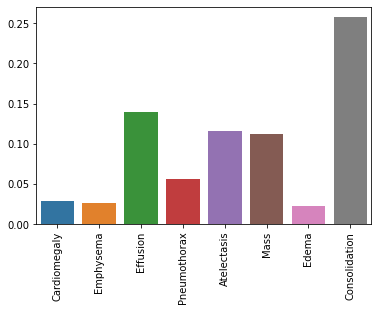

In [ ]:
class_probabilities = []
for i in PATHOLOGY_LIST:
  class_probabilities.append(working_df.loc[:,i].sum() / len(working_df))
class_probabilities = tf.constant(class_probabilities, dtype = 'float32')
sns.barplot(x = PATHOLOGY_LIST, y = class_probabilities.numpy())
plt.xticks(rotation = 90)

In [ ]:
augmented_df = working_df.copy()
for disease_name, df in diseases_dict.items():
  df_len = len(df)
  if disease_name in ['Cardiomegaly','Emphysema','Edema','Fibrosis']:
    sample = df.sample(frac = 3,replace = True)
  elif disease_name in ['Pneumothorax','Mass',]:
    sample = df.sample(frac = 2.2, replace = True)
  elif disease_name in ['Effusion','Atelectasis']:
    sample = df.sample(frac = .6, replace = True)
  # else:
    # sample = df.sample(frac = 0.2, replace = True)
  augmented_df = pd.concat((augmented_df, sample), axis = 0)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

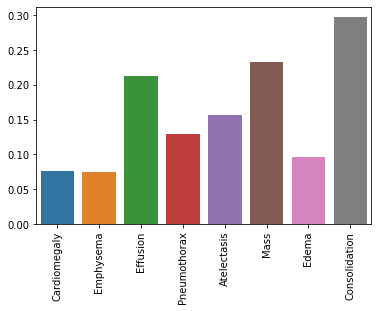

In [ ]:
class_probabilities = []
for i in PATHOLOGY_LIST:
  class_probabilities.append(augmented_df.loc[:,i].sum() / len(augmented_df))
class_probabilities = tf.constant(class_probabilities, dtype = 'float32')
sns.barplot(x = PATHOLOGY_LIST, y = class_probabilities.numpy())
plt.xticks(rotation = 90)

In [ ]:
augmented_df = augmented_df.replace((np.inf, -np.inf), np.nan)
augmented_df = augmented_df.dropna(axis = 0)

In [ ]:
augmented_df = augmented_df.reset_index(drop = True)
hernia = augmented_df[augmented_df['findings'] == 'Hernia']
augmented_df = augmented_df.drop(index = hernia.index)

#Maybe Processing

####All the dropping

In [ ]:
# working_df.sort_values('Follow-up #',ascending= False)
follow_up_patients = working_df['pt_id'].value_counts().index.values
follow_up_patients[:10]

array([10007., 12834., 13670., 13993., 15530.,  4808., 19124., 20213.,
       21201., 19176.])

So that I dont forget, the following patients are the ones in which im seeing all the cases which were labeled No finding and among them I have realised that the ones in the first are the ones which have no finding and all the others are bad.

In bekar_id all the xrays seem to be bad, and I can either discard the no findings of these or change them into the findings there are in the counter part.

In last good, the last of the xrays are better and jsut have to -1 for them

Remember that even for the ones whose inital cxr are fine, we can also go and check if we can get some relevant cxr to our problem514

did cases till 550

In [ ]:
i = 586

In [ ]:
with open('last_cxr.txt', 'a') as f:
    f.write(str(patient_id)+'\n')

In [ ]:
with open('worst_cxr.txt', 'a') as f:

    f.write(str(patient_id)+'\n')

In [ ]:
well = working_df[working_df['pt_id'] == follow_up_patients[i]]
all_cxr = len(well)
no_finding_cxr = len(well[well['findings'] == 'No Finding'])
finding_cxr = well[well['findings'] != 'No Finding']['findings'].value_counts()

wellwell = well[well['findings'] == 'No Finding']['path'].values[0]
wellwellmiddle = well[well['findings'] == 'No Finding']['path'].values[no_finding_cxr // 2]
wellwelllast = well[well['findings'] == 'No Finding']['path'].values[-1]

fig, ax = plt.subplots(1,3, figsize = (25,15))
patient_id = follow_up_patients[i]
ax[0].imshow(process_img(wellwell), cmap = 'gray')
ax[1].imshow(process_img(wellwellmiddle), cmap = 'gray')
ax[2].imshow(process_img(wellwelllast), cmap = 'gray')
print(len(well))
print(no_finding_cxr)
print(patient_id)
print(i)
print(finding_cxr)
i += 1

In [ ]:
sick_pt_id = worst_cxr[np.random.randint(0,len(worst_cxr))]
_df = working_df[working_df['pt_id'] == 12880]
nf_cxr = _df[_df['findings'] == 'No Finding']
f_cxr = _df[_df['findings'] != 'No Finding']
n = len(_df)
nf_n = len(nf_cxr)
f_n = len(f_cxr)

print('Total Cxr = {}, nf_cxr = {}, f_cxr = {}, Percentage NF = {:.2f}%  '.format(n, nf_n, f_n, nf_n / n * 100) )
all_findings = f_cxr['findings'].values
all_findings = '|'.join(all_findings).split('|')
all_findings = pd.Series(all_findings)
n_findings = all_findings.size
findings = all_findings.value_counts()
perc_findings = findings / n_findings * 100
print('Total Number of Findings = ', n_findings)
pd.concat((perc_findings, findings), axis = 1)

In [ ]:
temp_df = nf_cxr.sample(frac = 1)
x = 25
fig, ax = plt.subplots(3,3,figsize = (x,x))
ax = ax.flatten()
for i in range(9):
  img = temp_df['path'].values[i]
  pos = temp_df['position'].values[i]
  finding = temp_df['findings'].values[i]
  img = process_img(img)
  ax[i].imshow(img, cmap  = 'gray')
  ax[i].set_title((pos, finding))
  ax[i].axis('off')
plt.tight_layout()

#### I can maybe get out all the auto correlation of the different labels to see what are the chances of  a few diseasesa occuring together

#tf.data Pipeline

In [ ]:
# CONTRAST = (.2,.2)
# ZOOM = (-.2, .2)
# ROTATION = .05
# FILL_MODE = 'constant'
# INTERPOLATION = 'lanczos3'
# NOISE = 0.02

# configs.update({
#     'data_augmentation' : {
#         'contrast' : CONTRAST,
#         'zoom' : ZOOM,
#         'rotation' : ROTATION,
#         'fill_mode' : 'constant',
#         'interpolation' : INTERPOLATION,
#         'noise' : NOISE
#     }})

In [ ]:
data_augmentation = keras.Sequential([
  layers.Rescaling(1/255.),
  layers.RandomContrast(CONTRAST,seed = SEED),
  layers.RandomRotation(ROTATION, fill_mode = FILL_MODE, fill_value = 0., seed = SEED),
  layers.RandomZoom(height_factor = ZOOM, width_factor = ZOOM, fill_mode = FILL_MODE, fill_value = 0.,seed = SEED),
  layers.Resizing(height = configs['image_shape'][0], width = configs['image_shape'][0], interpolation = INTERPOLATION),
  layers.GaussianNoise(NOISE,seed = SEED),
])


In [ ]:
def new_parse_function(x, label):
  image_string = tf.io.read_file(x[0])

    #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_png(image_string, channels=3)

  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size = (IMG_SIZE[0], IMG_SIZE[0]), method=INTERPOLATION)

  image = tf.image.stateless_random_contrast(image, lower = CONTRAST[0], upper = CONTRAST[1], seed = SEED)
  image = tf.image.stateless_random_crop()
  image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  #Make sure the image is still in [0, 1]
  image = tf.clip_by_value(image, 0.0, 1.0)
  return (image, x[1]), label

In [ ]:


# pre_processing_model = keras.models.Sequential([
#                                   layers.Rescaling(1/255.),
#                                   layers.Resizing(height = configs['image_shape'][0], width = configs['image_shape'][0], interpolation = INTERPOLATION),
# ])

tf.config.run_functions_eagerly(True)

@tf.function
def get_one_hot_diseases(disease_cols, dataframe):
  _df = dataframe.copy()
  one_hot = _df.loc[:,disease_cols].values.astype('float32')
  return one_hot
  
@tf.function
def process_ds(x,y):
  _img = tf.io.read_file(x[0])
  _img = tf.io.decode_png(_img, channels = 3)
  # _img = _img / 255
  # _img = data_augmentation(_img)
  return (_img,x[1],), y

@tf.function
def df_to_dataset(dataframe, shuffle=True, batch_size=32, augment = False):
  df = dataframe.copy()
  labels = get_one_hot_diseases(PATHOLOGY_LIST, dataframe)
  # category_df = {key: value[:,tf.newaxis] for key, value in dataframe.loc[:,categorical_cols].items()}
  numeric_df = {key: value[:,tf.newaxis] for key, value in dataframe.loc[:,numerical_cols].items()}
  # image_df = {key: value for key, value in dataframe.loc[:,'Image'].items()}
  image_df = dataframe['path'].values
  ds = tf.data.Dataset.from_tensor_slices(((image_df, dict(numeric_df)), labels))
  # ds = ds.interleave(lambda z, j : ds.map(lambda x, y : process_ds(x,y,augment = augment), ), num_parallel_calls = tf.data.AUTOTUNE, )
  ds = ds.map(lambda x, y : process_ds(x,y), num_parallel_calls = -1)
  # ds = ds.cache('./some_cache')
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

#####Kidnly see to as how the map, prefetch and other things bring a change the time taken by your model

In [ ]:
img = augmented_df.path.values[38]
# show_img(img)
show_img(img)
img = tf.expand_dims(process_img(img), -1)
img = tf.cast(img, 'float32')

NotFoundError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
augment_img = data_augmentation(tf.expand_dims(img,0), training = True)
# plt.figure(figsize = (15,15))
# show_img(augment_img)
plt.imshow(augment_img[0,:,:,0], cmap = 'gray')
# augment_img[0], img[0]

In [ ]:
augment_img = data_augmentation(tf.expand_dims(img,0), training = True)
plt.figure(figsize = (15,15))
# show_img(augment_img)
plt.imshow(augment_img[0,:,:,0], cmap = 'gray')
# augment_img[0], img[0]

When using fine tuned model, we use the mean and variance of that model as that generally performs better as compared to out own decided stuff.

###Making Test, Validation and Test datsets

In [ ]:
from sklearn.model_selection import train_test_split

CURRENT_DF = augmented_df
train_df, interim_df = train_test_split(CURRENT_DF, test_size = 0.2, random_state = SEED, shuffle = True)
val_df, test_df = train_test_split(interim_df, test_size = 0.33, random_state = SEED, shuffle = True)

train_ds = df_to_dataset(train_df, shuffle = False, batch_size = configs['batch_size'])
val_ds = df_to_dataset(val_df, shuffle = False, batch_size = configs['batch_size'])
test_ds = df_to_dataset(test_df, shuffle = False, batch_size = configs['batch_size'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
iterator = train_ds.as_numpy_iterator()
for i in iterator:
  print(i)
  # print(i[0][0])
  break

((array([[[[189, 187, 197],
         [223, 213, 226],
         [214, 217, 211],
         ...,
         [ 13,   5,   5],
         [  9,  15,  19],
         [ 13,  13,   7]],

        [[198, 195, 197],
         [212, 215, 219],
         [209, 206, 213],
         ...,
         [ 10,  10,  13],
         [ 12,  16,  17],
         [ 20,  11,  19]],

        [[212, 201, 207],
         [199, 225, 211],
         [227, 220, 215],
         ...,
         [  8,  13,  19],
         [  9,  13,  17],
         [ 10,  20,  22]],

        ...,

        [[ 13,  13,   8],
         [ 17,  15,  14],
         [ 13,   6,  15],
         ...,
         [ 33,  32,  34],
         [ 41,  35,  33],
         [ 45,  36,  34]],

        [[ 15,  20,  12],
         [ 16,   6,  16],
         [ 17,  14,   5],
         ...,
         [ 38,  38,  44],
         [ 27,  34,  31],
         [ 44,  36,  43]],

        [[  7,  19,  10],
         [ 11,  14,  18],
         [ 19,  14,  20],
         ...,
         [ 37,  29,  31],
      

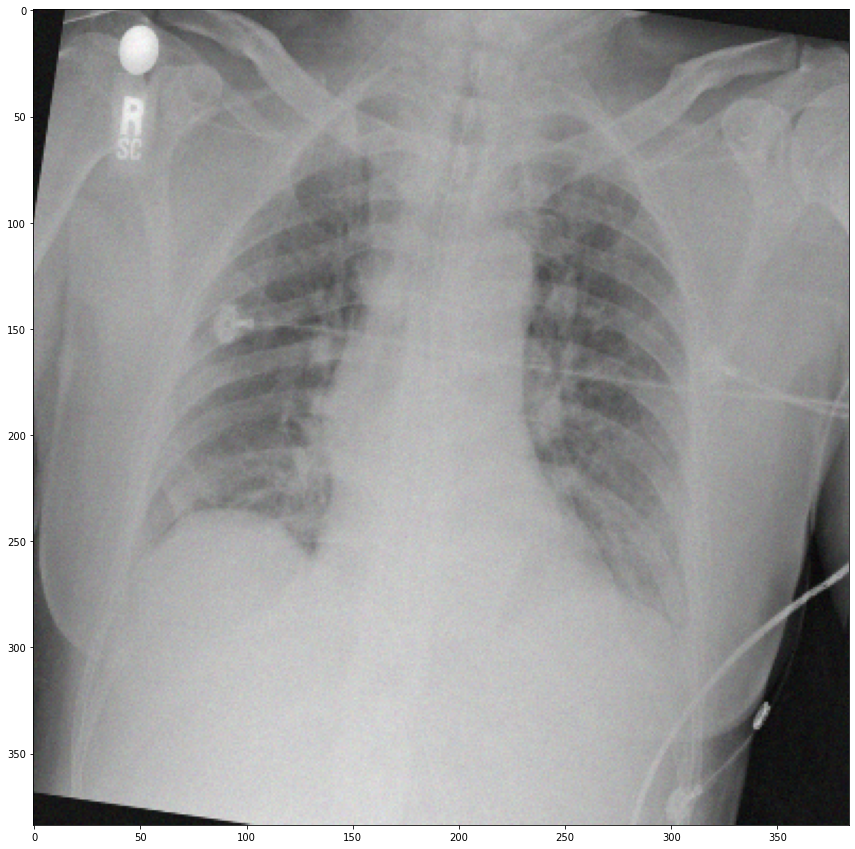

In [ ]:
example = next(iter(train_ds.take(1)))
plt.figure(figsize = (15,15))
plt.imshow(example[0][0][12] )

In [ ]:
example = next(iter(train_ds.take(1)))
plt.figure(figsize = (15,15))
plt.imshow(example[0][0][12] )

#wandb visualisation

In [ ]:
def one_hot_to_label(label):
  x = [x for x , y in zip(PATHOLOGY_LIST, label) if y == 1]
  return x

example_batch = list(train_ds.take(1))
images = example_batch[0][0][0].numpy()
numeric = example_batch[0][0][1]
categorical = example_batch[0][0][2]
labels = example_batch[0][1].numpy()
labels = [one_hot_to_label(x) for x in labels]

numeric_opened = {x : y.numpy() for x, y in numeric.items()}
categorical_opened = {x : y.numpy() for x, y in categorical.items()}
run = wandb.init(project = configs['data_flag'], group = 'Main Experiments', name = 'Augmented Effnet')

ds = wandb.Artifact('nih_all', 'dataset')

train_table = wandb.Table(columns = ['image', 'label', *numerical_cols, *categorical_cols], data = [])

i = 0
for image, label,  in zip(images, labels):
  data = [wandb.Image(image), label, ]
  for col in numerical_cols:
    data.append(numeric_opened.get(col)[i][0])
  for col in categorical_cols:
    data.append(categorical_opened.get(col)[i][0])
  train_table.add_data(*data)
  i += 1
ds['train_data'] = train_table
ds.save()
wandb.finish()

#Calculating Class Weights

In [ ]:
train_labels = train_df.loc[:,PATHOLOGY_LIST]
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.
    """
   
    N = labels.shape[0]
    positive_frequencies = np.sum(labels==1, axis=0)/N
    negative_frequencies = np.sum(labels==0, axis=0)/N
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_labels)

In [ ]:
freq_pos

Cardiomegaly     0.075409
Emphysema        0.074497
Effusion         0.210489
Pneumothorax     0.128576
Atelectasis      0.154932
Mass             0.234019
Edema            0.097135
Consolidation    0.296999
dtype: float64

In [ ]:
initial_bias = np.log(freq_pos/freq_neg)
initial_bias = tf.constant_initializer(initial_bias.values)
initial_bias

#Model

##Setup

In [ ]:
@tf.function
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

        # SO i have here, y_pred, which has a shape of (Batch_size, Predictions) and the loss will be calculated on the basis of this only. Now
        # what I want is that I have my negative and positive weights and I want more weightage to the positive prediction than the
        # negative prediction. This can be done by giving more emphasis on the loss due to negative predictions and incentivise the 
        # positive prediction

    return weighted_loss

In [ ]:


def categorical_preprocessing_model_constructor(categorical_cols, dataframe):
  categorical_inputs = {name:layers.Input(shape = (1,), dtype = 'string', name = f'input_{name}') for name in categorical_cols}

  categorical_outputs = {}

  for name, input in categorical_inputs.items():

    _output = tf.keras.layers.StringLookup(vocabulary=dataframe[name].unique(), output_mode = 'one_hot', name = f'output_{name}')
    categorical_outputs[name] = _output(input)
  
  outputs = layers.Concatenate()(categorical_outputs.values())

  model = keras.models.Model(categorical_inputs, outputs, name = 'categorical_preprocessing')

  return categorical_inputs, model

In [ ]:
def numerical_preprocessing_model_constructor(numerical_cols, dataframe):
  numerical_inputs = {name:layers.Input(shape = (1,), dtype = 'float32', name = f'input_{name}') for name in numerical_cols}

  numerical_outputs = {}
  for name, input in numerical_inputs.items():
    normalizer = layers.Normalization(name = f'normalizer_{name}')
    normalizer.adapt(dataframe[name])
    print(name, normalizer.adapt_mean, normalizer.adapt_variance)
    numerical_outputs[name] = normalizer(input)
  
  outputs = layers.Concatenate()(numerical_outputs.values())

  model = keras.models.Model(numerical_inputs, outputs, name = 'numerical_preprocessing')

  # This is so we dont get that .h5 error, due to duplicacy and shit
  for i, layer in enumerate(model.weights):
    model.weights[i]._handle_name = layer.name + f'_{i}'

  return numerical_inputs, model

In [ ]:
mean_variance = (
('age' , 47.665493, 272.06888),
('ct_ratio' , 0.4618522, 36.127007),
('ct_area' , 0.34165946, 0.03970006),
('right_cp_angle' , 59.87151, 357.14566),
('right_cp_angle_direction' , 66.51969, 116.827),
('left_cp_angle' , 59.12783, 354.2199),
('left_cp_angle_direction' , 68.92506, 117.35716),
('cp_rel_position' , 0.9664104, 0.01739207),
('height_width_ratio' , 0.92575467, 42.961063),
('area_ratio' , 1.2086499, 4.6026187),
('vertical_span_ratio' , 0.96713364, 0.05407601),)

def numerical_preprocessing_model_constructor(numerical_cols, dataframe):
  numerical_inputs = {name:layers.Input(shape = (1,), dtype = 'float32', name = f'input_{name}') for name in numerical_cols}

  numerical_outputs = {}
  for (name, mean, variance), (_,input) in zip(mean_variance, numerical_inputs.items()) :
    normalizer = layers.Normalization(name = f'normalizer_{name}', mean = mean, variance = variance)
    print(mean)
    numerical_outputs[name] = normalizer(input)
  
  outputs = layers.Concatenate()(numerical_outputs.values())

  model = keras.models.Model(numerical_inputs, outputs, name = 'numerical_preprocessing')

  # This is so we dont get that .h5 error, due to duplicacy and shit
  for i, layer in enumerate(model.weights):
    model.weights[i]._handle_name = layer.name + f'_{i}'

  return numerical_inputs, model

In [ ]:
def img_preprocessing_model_constructor():
  model = keras.models.Sequential([
                                   layers.Rescaling(scale = 1./255, name = 'img_rescaling')
  ])
  return model

##Model with DenseHead Pretrained

###Architecture

In [ ]:
categorical_inputs, categorical_pre_processing_model = categorical_preprocessing_model_constructor(categorical_cols, CURRENT_DF)
numerical_inputs, numerical_pre_processing_model = numerical_preprocessing_model_constructor(numerical_cols, CURRENT_DF)
img_pre_processing_model = img_preprocessing_model_constructor()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2S
img_feature_extractor = EfficientNetV2S(input_shape = (224,224,3), include_top=False, weights = 'imagenet')

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
def get_model(name):
  regularizer = keras.regularizers.L2(.007)

  # Auxillary Features Line
  numerical_features = numerical_pre_processing_model(numerical_inputs)
  categorical_features = categorical_pre_processing_model(categorical_inputs)
  # Joining the auxillary line
  aux_line = layers.Concatenate(name = 'concat_aux_line')([numerical_features, categorical_features])

  # Image Line
  input_img = layers.Input(shape = (None,None,None), name = 'image_input')
  img_line = img_pre_processing_model(input_img)
  img_line = img_feature_extractor(img_line)
  img_line_output = layers.GlobalAveragePooling2D(name = 'glob_pool')(img_line)
  img_line_output = layers.Dropout(0.5, name = 'dropout_img')(img_line_output)


  # Common Layer from here on
  common_line = layers.Concatenate(name = 'common_line_start')([img_line_output, aux_line])

  common_line = layers.Dense(512, 'relu', kernel_regularizer = regularizer, bias_regularizer = regularizer, name = 'dense1')(common_line)
  common_line = layers.Dropout(0.4, name = 'mid_dense_dropout')(common_line)
  common_line = layers.Dense(512, 'relu', kernel_regularizer = regularizer, bias_regularizer = regularizer, name = 'dense2')(common_line)
  # output = layers.Dense(len(pathology_list), activation = 'sigmoid', bias_initializer=initial_bias)(common_line)
  output = layers.Dense(len(PATHOLOGY_LIST), activation = 'sigmoid',bias_initializer=initial_bias, dtype = 'float32', name = 'output')(common_line)

  model = keras.models.Model(inputs = (input_img, numerical_inputs, categorical_inputs), outputs = output, name = name)
  return model
  # tf.keras.utils.plot_model(model_eff_M_reg_densehead, show_shapes = True, rankdir='LR')

###Compile

In [ ]:
import utils.evaluation as eval
params =   {
    'max_lr' : 1e-3,
    'start_lr': 1e-5,
    'rampup_epochs' : 4,
    'sustain_epochs' : 0,
    'exp_decay': 0.85,
    'optimizer' : keras.optimizer_v2.adam.Adam(),
    'loss' : get_weighted_loss(freq_pos.values, freq_neg.values),
    'epochs' : 100,
    'metrics' : eval.statistical_metrics(0.15)
}
configs.update(params)

run = wandb.init(
                id = '2i28gx2f',
                project = configs.get('data_flag'), 
                 job_type = 'train', 
                 config= configs,
                 group = 'Main Experiments',
                 name = 'Weighted BCE Pretrained',
                 notes = """ 
                 Pretrained Model on EffnetV2S
                 """,
                 dir = 'wandb_model',
                 resume = 'must'                 
                 )

config = wandb.config
wandb.save(os.path.join(wandb.run.dir, "checkpoint*"))

wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


[]

In [ ]:
# path = os.path.join(run.dir, 'checkpoint_model')
# path
run.resumed

True

In [ ]:

wandb_callback = wandb.keras.WandbCallback(
    monitor = 'val_prc',
    mode = 'max',
    save_model = True,
    log_evaluation = True,
    validation_data = val_ds,
    validation_steps = val_ds.cardinality(),
    labels = PATHOLOGY_LIST
    )

ramp_schedule = nn_advanced.lrfn(max_lr = config.max_lr, 
                                 start_lr = config.start_lr,
                                 rampup_epochs = config.rampup_epochs,
                                 sustain_epochs= config.sustain_epochs,
                                 exp_decay = config.exp_decay)

reduce_lr = keras.callbacks.LearningRateScheduler(ramp_schedule, verbose = 1)
path = os.path.join(run.dir, 'checkpoint_model')
chkpt = keras.callbacks.ModelCheckpoint(path, monitor = 'val_prc',
                                        mode = 'max', save_best_only = True, 
                                        save_weights_only = True
                                        )
# tf.keras.backend.clear_session()
# model_name = 'full_weighted_bce_effnet_s'

# model = get_model('pretrained_effnet')



# model.compile(loss = configs['loss'],
#               optimizer = configs['optimizer'],
#               metrics = configs['metrics'])

model.fit(
    train_ds,
    epochs = config.epochs,
    validation_data = val_ds,
    callbacks = [
                 wandb_callback,
                 reduce_lr,
                 chkpt
    ]
)

acc = model_w_bce.evaluate(test_ds)
wandb.log({'loss' : acc[0], 'prc' : acc[-1], 'auc' : acc[-2]})

wandb.finish()

wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: 'PrefetchDataset' object is not subscriptable



Epoch 23: LearningRateScheduler setting learning rate to 6.310994570750061e-05.
Epoch 23/100
2465/2465 [==============================] - 2221s 901ms/step - loss: 0.0396 - tp: 196644.0000 - fp: 276.0000 - tn: 1214195.0000 - fn: 8302.0000 - accuracy: 0.9936 - precision: 0.9986 - recall: 0.9595 - auc: 0.9820 - prc: 0.9755 - val_loss: 0.5263 - val_tp: 30009.0000 - val_fp: 2487.0000 - val_tn: 200691.0000 - val_fn: 4566.0000 - val_accuracy: 0.9711 - val_precision: 0.9235 - val_recall: 0.8679 - val_auc: 0.9399 - val_prc: 0.8910 - _timestamp: 1654429711.0000 - _runtime: 54888.0000 - lr: 6.3110e-05

Epoch 24: LearningRateScheduler setting learning rate to 5.514345385137552e-05.
Epoch 24/100
2465/2465 [==============================] - 2201s 893ms/step - loss: 0.0382 - tp: 196824.0000 - fp: 284.0000 - tn: 1214187.0000 - fn: 8122.0000 - accuracy: 0.9937 - precision: 0.9986 - recall: 0.9604 - auc: 0.9821 - prc: 0.9757 - val_loss: 0.5731 - val_tp: 28526.0000 - val_fp: 2462.0000 - val_tn: 200716.0

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

accuracy,▁▃█
auc,▁▄█
epoch,▁▅█
fn,█▅▁
fp,▇█▁
loss,█▆▁
prc,▁▄█
precision,▂▁█
recall,▁▄█
tn,▂▁█
tp,▁▄█


##Model with DenseHead Augmented and Redundant classes removed

Also added a class of abnormal so that am able to make sure that nothing is missed

Got to know about concpet of BYOL and self supervised learnfing and that may be of some use

In [ ]:
mean_variance = (
('age' , 47.665493, 272.06888),
('ct_ratio' , 0.4618522, 36.127007),
('ct_area' , 0.34165946, 0.03970006),
('right_cp_angle' , 59.87151, 357.14566),
('right_cp_angle_direction' , 66.51969, 116.827),
('left_cp_angle' , 59.12783, 354.2199),
('left_cp_angle_direction' , 68.92506, 117.35716),
('cp_rel_position' , 0.9664104, 0.01739207),
('height_width_ratio' , 0.92575467, 42.961063),
('area_ratio' , 1.2086499, 4.6026187),
('vertical_span_ratio' , 0.96713364, 0.05407601),)

###Architecture

In [ ]:
categorical_inputs, categorical_pre_processing_model = categorical_preprocessing_model_constructor(categorical_cols, CURRENT_DF)
numerical_inputs, numerical_pre_processing_model = numerical_preprocessing_model_constructor(numerical_cols, CURRENT_DF)
img_pre_processing_model = img_preprocessing_model_constructor()

47.665493
0.4618522
0.34165946
59.87151
66.51969
59.12783
68.92506
0.9664104


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2S
img_feature_extractor = EfficientNetV2S(input_shape = INPUT_SHAPE, include_top=False, weights = 'imagenet', )
img_feature_extractor.trainable = True

In [ ]:
configs.update({
    'regularisation' : .0009,
    'dropout_rate' : 0.3
})

def get_model(name):

  regularizer = keras.regularizers.L2(configs['regularisation'])

  # Auxillary Features Line
  numerical_features = numerical_pre_processing_model(numerical_inputs)
  # categorical_features = categorical_pre_processing_model(categorical_inputs)
  # Joining the auxillary line
  # aux_line = layers.Concatenate(name = 'concat_aux_line')([numerical_features, categorical_features])

  # Image Line
  input_img = layers.Input(shape = INPUT_SHAPE, name = 'image_input')
  img_line = img_feature_extractor(input_img)
  img_line_output = layers.GlobalAveragePooling2D(name = 'glob_pool')(img_line)
  img_line_output = layers.Dropout(configs['dropout_rate'], name = 'dropout_img')(img_line_output)


  # Common Layer from here on
  common_line = layers.Concatenate(name = 'common_line_start')([img_line_output, numerical_features])

  common_line = layers.Dense(512, 'relu',  name = 'dense1')(common_line)
  # common_line = layers.Dropout(configs['dropout_rate'], name = 'mid_dense_dropout')(common_line)
  common_line = layers.Dense(512, 'relu',  name = 'dense2')(common_line)
  # output = layers.Dense(len(pathology_list), activation = 'sigmoid', bias_initializer=initial_bias)(common_line)
  output = layers.Dense(len(PATHOLOGY_LIST), activation = 'sigmoid', dtype = 'float32', name = 'output')(common_line)

  model = keras.models.Model(inputs = (input_img, numerical_inputs), outputs = output, name = name)
  return model

In [ ]:
model = get_model('msldf')
model.compile(loss = keras.losses.mse,
              optimizer = keras.optimizer_v2.adam.Adam())
model.fit(train_ds, epochs = 3)

ResourceExhaustedError: ignored

###Compile

In [ ]:
import utils.evaluation as eval
params =   {
    'max_lr' : 1e-3,
    'start_lr': 1e-5,
    'rampup_epochs' : 5,
    'sustain_epochs' : 3,
    'exp_decay': 0.93,
    'optimizer' : keras.optimizer_v2.adam.Adam(),
    'loss' : get_weighted_loss(freq_pos.values, freq_neg.values),
    'epochs' : 50,
    'metrics' : eval.statistical_metrics(0.1)
}
configs.update(params)

# run = wandb.init(
#                 project = configs.get('data_flag'), 
#                  job_type = 'train', 
#                  config= configs,
#                  group = 'Main Experiments',
#                  name = 'Heavily augmented Pretrained Model EffB0',
#                  notes = """ 
#                  As my previous model was taking very long to train, in the meantime, tried it on a smaller model
#                  """,
#                  )

# config = wandb.config

In [ ]:
import importlib
importlib.reload(nn_advanced)

<module 'utils.nn_advanced' from '/content/utils/nn_advanced.py'>

In [ ]:

wandb_callback = wandb.keras.WandbCallback(
    monitor = 'val_prc',
    mode = 'max',
    save_model = True,
    log_evaluation = True,
    validation_data = val_ds,
    validation_steps = val_ds.cardinality(),
    labels = PATHOLOGY_LIST
    )

ramp_schedule = nn_advanced.lrfn(max_lr = config.max_lr, 
                                 start_lr = config.start_lr,
                                 rampup_epochs = config.rampup_epochs,
                                 sustain_epochs= config.sustain_epochs,
                                 exp_decay = config.exp_decay)

reduce_lr = keras.callbacks.LearningRateScheduler(ramp_schedule, verbose = 1)
# path = os.path.join(run.dir, 'checkpoint_model')
chkpt = keras.callbacks.ModelCheckpoint('./drive/MyDrive/Models/augmented_pretrained_effb0.h5', monitor = 'val_prc',
                                        mode = 'max', save_best_only = True, 
                                        save_weights_only = True
                                        )
# tf.keras.backend.clear_session()
# model_name = 'full_weighted_bce_effnet_s'

# model = get_model('pretrained_effnet')



model = get_model('augmented_pretrained_effb0')

model.compile(loss = configs['loss'],
              optimizer = configs['optimizer'],
              metrics = configs['metrics'])

model.fit(
    train_ds,
    epochs = config.epochs,
    validation_data = val_ds,
    callbacks = [
                 wandb_callback,
                 reduce_lr,
                 chkpt
    ]
)

acc = model_w_bce.evaluate(test_ds)
wandb.log({'loss' : acc[0], 'prc' : acc[-1], 'auc' : acc[-2]})

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: 'PrefetchDataset' object is not subscriptable



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
  46/4800 [..............................] - ETA: 59:21 - loss: 6.8098 - tp: 1135.0000 - fp: 5824.0000 - tn: 4040.0000 - fn: 777.0000 - accuracy: 0.6260 - precision: 0.1631 - recall: 0.5936 - auc: 0.4872 - prc: 0.1533

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

lr,▁
lr,0.001


In [ ]:
with wandb.init(project='nih_all') as run:
  artifact = wandb.Artifact('nih_all', 'dataset')
  artifact.add_file('./augmented_zip_images.zip')
  wandb.log_artifact(artifact)

In [ ]:
wandb.restore

AttributeError: ignored

##2nd Augmented MOdel

In [ ]:
mean_variance = (
('age' , 47.665493, 272.06888),
('ct_ratio' , 0.4618522, 36.127007),
('ct_area' , 0.34165946, 0.03970006),
('right_cp_angle' , 59.87151, 357.14566),
('right_cp_angle_direction' , 66.51969, 116.827),
('left_cp_angle' , 59.12783, 354.2199),
('left_cp_angle_direction' , 68.92506, 117.35716),
('cp_rel_position' , 0.9664104, 0.01739207),
('height_width_ratio' , 0.92575467, 42.961063),
('area_ratio' , 1.2086499, 4.6026187),
('vertical_span_ratio' , 0.96713364, 0.05407601),)

###Architecture

In [ ]:
categorical_inputs, categorical_pre_processing_model = categorical_preprocessing_model_constructor(categorical_cols, CURRENT_DF)
numerical_inputs, numerical_pre_processing_model = numerical_preprocessing_model_constructor(numerical_cols, CURRENT_DF)
img_pre_processing_model = img_preprocessing_model_constructor()

47.665493
0.4618522
0.34165946
59.87151
66.51969
59.12783
68.92506
0.9664104


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2S
img_feature_extractor = EfficientNetV2S(input_shape = INPUT_SHAPE, include_top=False, weights = 'imagenet', )
img_feature_extractor.trainable = True

82436096/82420632 [==============================] - 2s 0us/step


In [ ]:
configs.update({
    'regularisation' : .0009,
    'dropout_rate' : 0.3
})

def get_model(name):

  regularizer = keras.regularizers.L2(configs['regularisation'])

  # Auxillary Features Line
  numerical_features = numerical_pre_processing_model(numerical_inputs)
  # categorical_features = categorical_pre_processing_model(categorical_inputs)
  # Joining the auxillary line
  # aux_line = layers.Concatenate(name = 'concat_aux_line')([numerical_features, categorical_features])

  # Image Line
  input_img = layers.Input(shape = INPUT_SHAPE, name = 'image_input')
  input_img = img_pre_processing_model(input_img)
  img_line = img_feature_extractor(input_img)
  img_line_output = layers.GlobalAveragePooling2D(name = 'glob_pool')(img_line)
  img_line_output = layers.Dropout(configs['dropout_rate'], name = 'dropout_img')(img_line_output)


  # Common Layer from here on
  common_line = layers.Concatenate(name = 'common_line_start')([img_line_output, numerical_features])

  common_line = layers.Dense(1024, 'relu',  name = 'dense1')(common_line)
  # common_line = layers.Dropout(configs['dropout_rate'], name = 'mid_dense_dropout')(common_line)
  common_line = layers.Dense(1024, 'relu',  name = 'dense2')(common_line)
  # output = layers.Dense(len(pathology_list), activation = 'sigmoid', bias_initializer=initial_bias)(common_line)
  output = layers.Dense(len(PATHOLOGY_LIST), activation = 'sigmoid', dtype = 'float32', name = 'output')(common_line)

  model = keras.models.Model(inputs = (input_img, numerical_inputs), outputs = output, name = name)
  return model

In [ ]:
model = get_model('msldf')
model.compile(loss = keras.losses.mse,
              optimizer = keras.optimizer_v2.adam.Adam())
model.fit(train_ds, epochs = 3)

###Compile

In [ ]:
import utils.evaluation as eval
params =   {
    'max_lr' : 1e-3,
    'start_lr': 1e-5,
    'rampup_epochs' : 5,
    'sustain_epochs' : 2,
    'exp_decay': 0.93,
    'optimizer' : keras.optimizer_v2.adam.Adam(),
    'loss' : get_weighted_loss(freq_pos.values, freq_neg.values),
    'epochs' : 50,
    'metrics' : eval.statistical_metrics(0.1)
}
configs.update(params)

# run = wandb.init(
#                 project = configs.get('data_flag'), 
#                  job_type = 'train', 
#                  config= configs,
#                  group = 'Main Experiments',
#                  name = 'Heavily augmented Pretrained Model EffB0',
#                  notes = """ 
#                  As my previous model was taking very long to train, in the meantime, tried it on a smaller model
#                  """,
#                  )

# config = wandb.config

In [ ]:
import importlib
importlib.reload(nn_advanced)

<module 'utils.nn_advanced' from '/content/utils/nn_advanced.py'>

In [ ]:

wandb_callback = wandb.keras.WandbCallback(
    monitor = 'val_prc',
    mode = 'max',
    save_model = True,
    log_evaluation = True,
    validation_data = val_ds,
    validation_steps = val_ds.cardinality(),
    labels = PATHOLOGY_LIST
    )

ramp_schedule = nn_advanced.lrfn(max_lr = config.max_lr, 
                                 start_lr = config.start_lr,
                                 rampup_epochs = config.rampup_epochs,
                                 sustain_epochs= config.sustain_epochs,
                                 exp_decay = config.exp_decay)

reduce_lr = keras.callbacks.LearningRateScheduler(ramp_schedule, verbose = 1)
# path = os.path.join(run.dir, 'checkpoint_model')
chkpt = keras.callbacks.ModelCheckpoint('./drive/MyDrive/Models/augmented_pretrained_effb0.h5', monitor = 'val_prc',
                                        mode = 'max', save_best_only = True, 
                                        save_weights_only = True
                                        )
# tf.keras.backend.clear_session()
# model_name = 'full_weighted_bce_effnet_s'

# model = get_model('pretrained_effnet')



model = get_model('augmented_pretrained_effb0')

model.compile(loss = configs['loss'],
              optimizer = configs['optimizer'],
              metrics = configs['metrics'])

model.fit(
    train_ds,
    epochs = config.epochs,
    validation_data = val_ds,
    callbacks = [
                 wandb_callback,
                 reduce_lr,
                 chkpt
    ]
)

acc = model_w_bce.evaluate(test_ds)
wandb.log({'loss' : acc[0], 'prc' : acc[-1], 'auc' : acc[-2]})

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: 'PrefetchDataset' object is not subscriptable



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
  46/4800 [..............................] - ETA: 59:21 - loss: 6.8098 - tp: 1135.0000 - fp: 5824.0000 - tn: 4040.0000 - fn: 777.0000 - accuracy: 0.6260 - precision: 0.1631 - recall: 0.5936 - auc: 0.4872 - prc: 0.1533

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

lr,▁
lr,0.001


In [ ]:
with wandb.init(project='nih_all') as run:
  artifact = wandb.Artifact('nih_all', 'dataset')
  artifact.add_file('./augmented_zip_images.zip')
  wandb.log_artifact(artifact)

In [ ]:
wandb.restore

AttributeError: ignored

##Model 2 (ViT)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

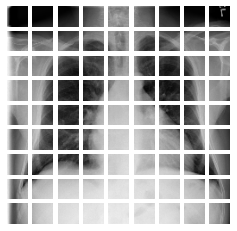

In [ ]:
PATCH_SIZE = 24
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1,self.patch_size, self.patch_size, 1],
        strides = [1,self.patch_size,self.patch_size, 1],
        rates = [1,1,1,1],
        padding = 'VALID',
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

# img = process_img(working_df['path'].values[0])
img = tf.io.read_file(working_df['path'].values[0])
img = tf.image.decode_image(img, configs['channels']=3)
img = tf.image.resize(img, (224,224))
img = tf.expand_dims(img, 0)
patches = Patches(PATCH_SIZE)(img)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

#Evaluation

In [ ]:
wandb.init(id = 'nih_all_heavy_augment', project = configs.get('data_flag'), resume = 'must')

lr,▁
lr,0.001


In [ ]:
model = wandb.restore('model-best.h5')

In [ ]:
# !cp ./drive/MyDrive/Models/augmented_pretrained_3.h5 ./augmented_pretrained_3.h5
# model = get_model('jsdf')
# model.load_weights('augmented_pretrained.h5',)
model = keras.models.load_model('augmented_pretrained_3.h5', custom_objects = {'weighted_loss':configs['loss']})
# model

In [ ]:
CURRENT_MODEL = model

In [ ]:
model_mob_net.load_weights('2nd_gen.ckpt')

In [ ]:
!zip -r ./augmented_zip_images.zip ./augmented/

In [ ]:
eval = CURRENT_MODEL.evaluate(test_ds,)
for name, value in zip(CURRENT_MODEL.metrics_names, eval):
  print(name, ':', value)

107/396 [=======>......................] - ETA: 2:16 - loss: 0.6671 - tp: 2841.0000 - fp: 1631.0000 - tn: 21326.0000 - fn: 1594.0000 - accuracy: 0.8745 - precision: 0.6353 - recall: 0.6406 - auc: 0.8948 - prc: 0.6832

KeyboardInterrupt: ignored

In [ ]:
eval = CURRENT_MODEL.evaluate(test_ds, callbacks=[csv_cb])
for name, value in zip(CURRENT_MODEL.metrics_names, eval):
  print(name, ':', value)

18/18 [==============================] - 7s 355ms/step - loss: 0.2847 - tp: 1300.0000 - fp: 35.0000 - tn: 12580.0000 - fn: 255.0000 - accuracy: 0.9798 - precision: 0.9738 - recall: 0.8360 - auc: 0.9540 - prc: 0.9220
loss : 0.28470730781555176
tp : 1300.0
fp : 35.0
tn : 12580.0
fn : 255.0
accuracy : 0.9798163771629333
precision : 0.9737827777862549
recall : 0.8360128402709961
auc : 0.953984797000885
prc : 0.9220450520515442


array([['Cardiomegaly', '0.0', '1e-04'],
       ['Emphysema', '0.0', '0.0003'],
       ['Effusion', '0.0', '0.0045'],
       ['Pneumothorax', '0.0', '0.0015'],
       ['Atelectasis', '0.0', '0.0225'],
       ['Pleural_Thickening', '0.0', '0.0002'],
       ['Mass', '0.0', '0.0021'],
       ['Edema', '0.0', '0.0'],
       ['Consolidation', '0.0', '0.0635'],
       ['Fibrosis', '0.0', '0.0']], dtype='<U32')

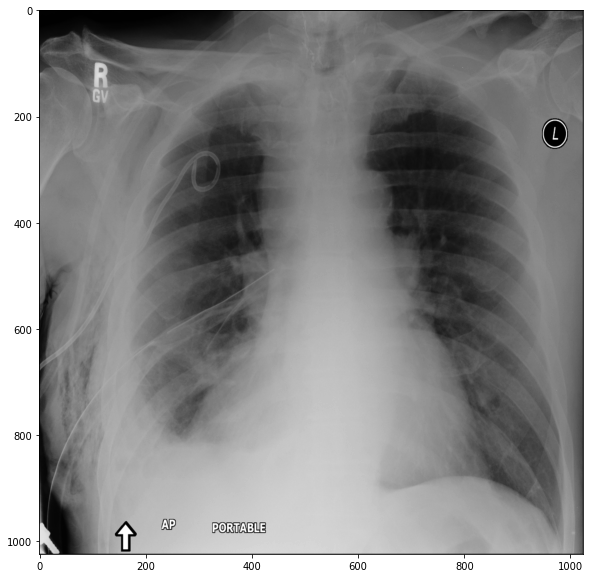

In [ ]:
i = np.random.randint(0,BATCH_SIZE)
example_batch = next(iter(test_ds.take(1)))
plt.figure(figsize = (10,10))
plt.grid(False)
plt.imshow(example_batch[0][0][i].numpy()[:,:,0], cmap = 'gray')
predictions = CURRENT_MODEL(example_batch[0])
np.array((PATHOLOGY_LIST,example_batch[1][i], np.round(predictions[i],4))).T

In [ ]:
test_predictions = CURRENT_MODEL.predict(test_ds)
test_labels = get_one_hot_diseases(PATHOLOGY_LIST,test_df)

NotFoundError: ignored

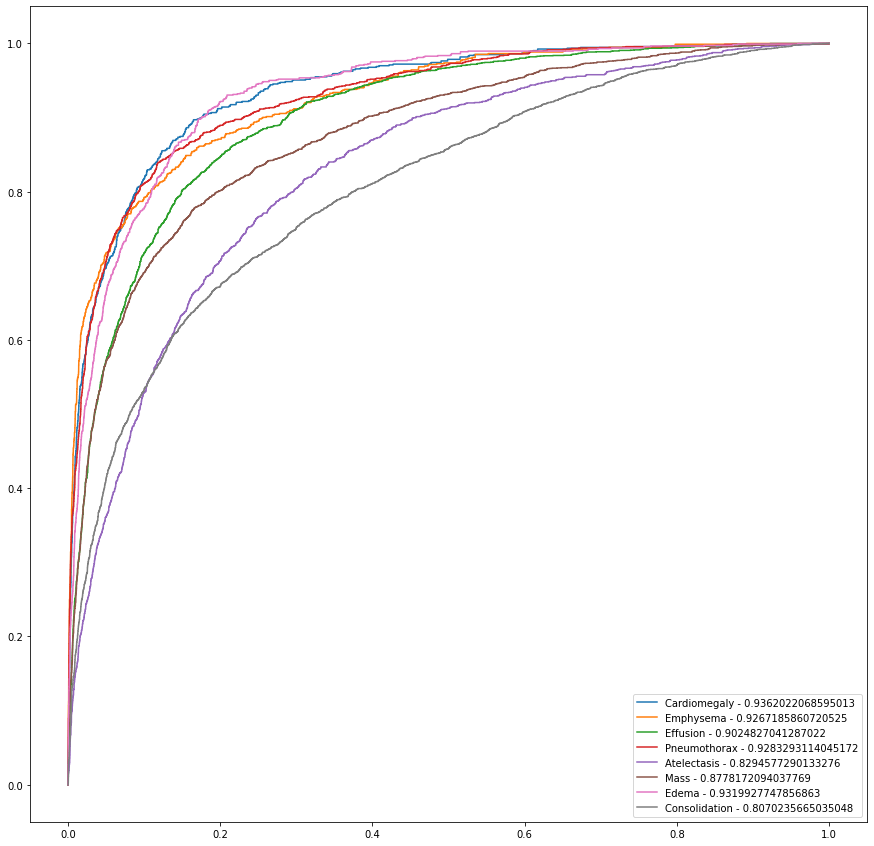

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# predictions, test_labels
plt.figure(figsize = (15,15))
test_labels = np.array(test_labels)
test_labels.shape
for i in range(len(PATHOLOGY_LIST)):
  fpr, tpr , _ = roc_curve(test_labels[:,i], test_predictions[:,i])
  score = roc_auc_score(test_labels[:,i], test_predictions[:,i])
  plt.plot(fpr, tpr, label = f'{PATHOLOGY_LIST[i]} - {score}')
  plt.legend()

In [ ]:
img = tf.io.read_file('./CHNCXR_0599_1.png')
img = tf.image.decode_png(img, channels = 3)
img = tf.image.convert_image_dtype(img, 'float32')
img = tf.image.resize(img, (384,384))
numer = dict(working_df.loc[9,numerical_cols])
numer = {key:tf.convert_to_tensor([value]) for key, value in numer.items()}
CURRENT_MODEL.predict((tf.expand_dims(img,0),numer) )
# numer

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[0.00047094, 0.00391224, 0.35037196, 0.01925838, 0.01974223,
        0.08239608, 0.00363317, 0.07614783]], dtype=float32)

In [ ]:
wandb.finish()

accuracy,0.89224
auc,0.91713
best_epoch,7
best_val_prc,0.68947
epoch,9
fn,58694
fp,69144
loss,0.54664
prc,0.76215
precision,0.66472
recall,0.7002


IndexError: ignored

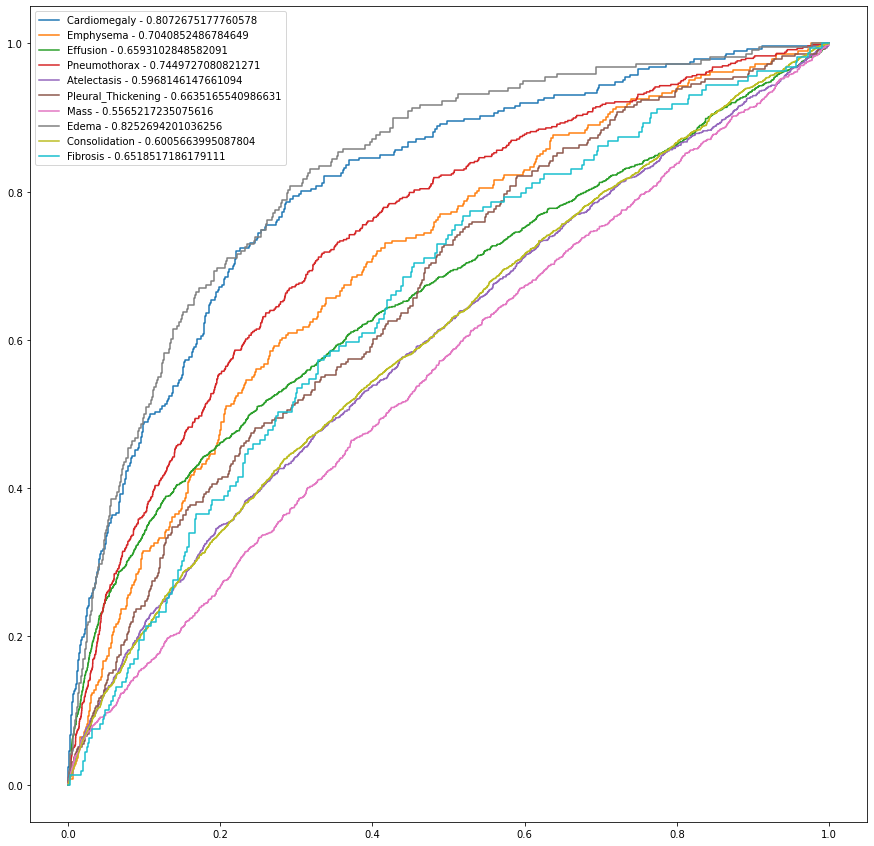

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# predictions, test_labels
plt.figure(figsize = (15,15))
test_labels = np.array(test_labels)
test_labels.shape
for i in range(13):
  fpr, tpr , _ = roc_curve(test_labels[:,i], test_predictions[:,i])
  score = roc_auc_score(test_labels[:,i], test_predictions[:,i])
  plt.plot(fpr, tpr, label = f'{PATHOLOGY_LIST[i]} - {score}')
  plt.legend()

In [ ]:
def plot_cf_matrix_predictions(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true,y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

def plot_cf_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix_dict = {}
for i, disease in enumerate(PATHOLOGY_LIST):
  pred = [1 if x > 0.4 else 0 for x in test_predictions[:,i]]
  c_matrix = confusion_matrix(test_labels[:,i],pred)
  conf_matrix_dict[disease] = c_matrix


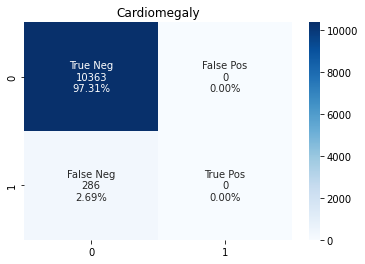

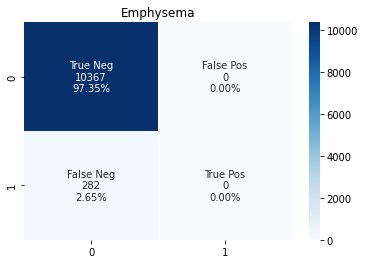

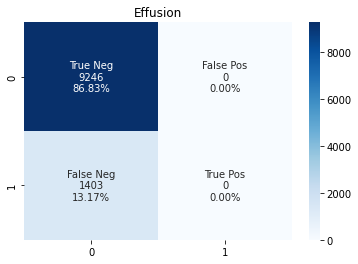

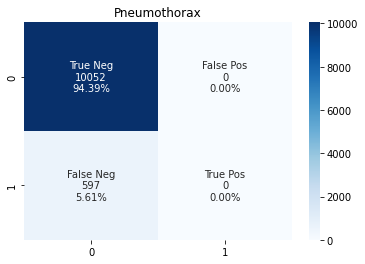

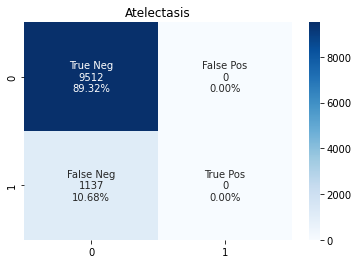

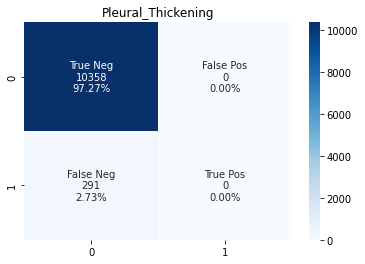

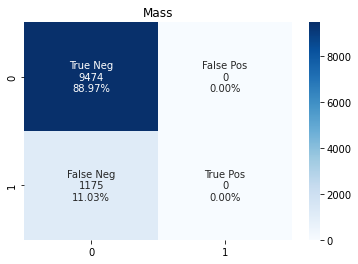

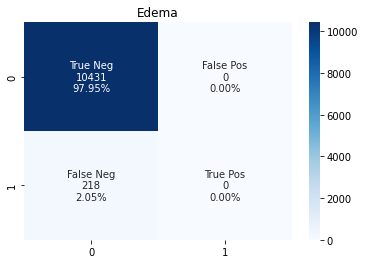

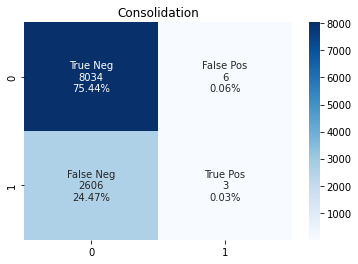

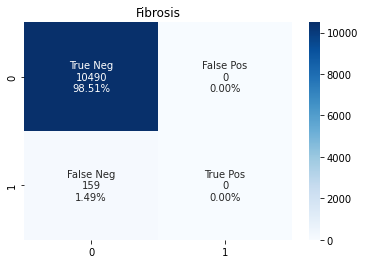

In [ ]:
for i in PATHOLOGY_LIST:
  plt.title(i)
  plot_cf_matrix(conf_matrix_dict[i])
  plt.show()

[]

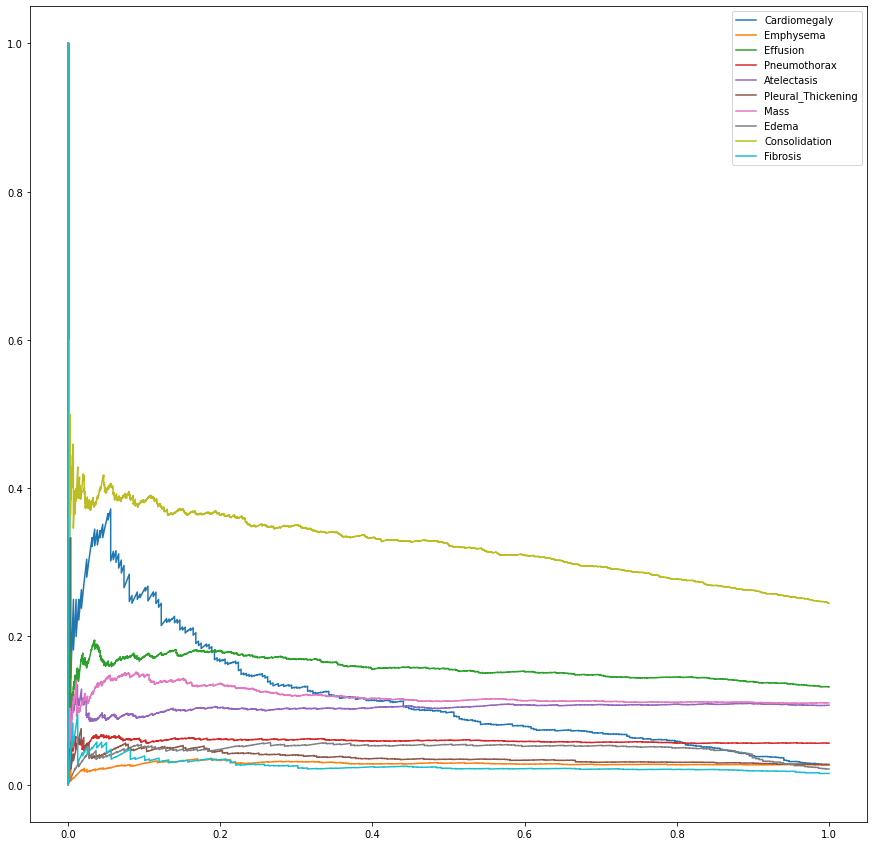

In [ ]:
from sklearn import metrics
precision = {}
recall = {}
average_precision = {}
plt.figure(figsize =( 15,15))
for i, disease in enumerate(PATHOLOGY_LIST):
  precision[disease], recall[disease], thresh = metrics.precision_recall_curve(test_labels[:,i], test_predictions[:,i])
  average_precision[disease] = metrics.average_precision_score(test_labels[:,i], test_predictions[:,i])
  plt.plot(recall[disease], precision[disease], label = disease)
  plt.legend()
plt.plot()

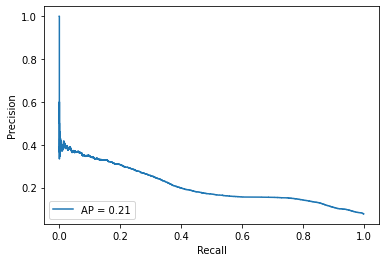

In [ ]:
micro_avg_precision = metrics.average_precision_score(test_labels, test_predictions, average = 'micro')
prec_micro, recall_micro, _  = metrics.precision_recall_curve(test_labels.ravel(), test_predictions.ravel())
woah = metrics.PrecisionRecallDisplay(precision =prec_micro, recall = recall_micro,average_precision= micro_avg_precision)
woah.plot()

#Misc

In [ ]:
bbox_df = pd.read_csv('./BBox_List_2017.csv')
bbox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [ ]:
complete_df = pd.read_csv('./Data_Entry_2017.csv')

In [ ]:
bbox_df = pd.merge(working_df, bbox_df,how = 'inner', on = 'Image Index')

In [ ]:
bbox_df.loc[:,[]]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Pneumonia,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00000032_037.png,Cardiomegaly|Edema|Infiltration,37,32,55,F,AP,2500,2048,0.168000,...,0,0,Infiltrate,339.166138,119.195767,172.292063,351.085714,NaN,NaN,NaN
1,00000072_000.png,Atelectasis,0,72,67,F,PA,2450,2839,0.143000,...,0,0,Atelectasis,356.503704,567.805291,127.864550,82.353439,NaN,NaN,NaN
2,00000147_001.png,Atelectasis,1,147,66,F,PA,2742,2948,0.143000,...,0,0,Atelectasis,617.650794,599.229630,100.774603,179.877249,NaN,NaN,NaN
3,00000149_006.png,Atelectasis,6,149,71,M,AP,2500,2048,0.168000,...,0,0,Atelectasis,603.661017,460.239556,249.491525,90.033898,NaN,NaN,NaN
4,00000150_002.png,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,3056,2544,0.139000,...,0,1,Pneumonia,601.396825,595.978836,215.635979,180.960847,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,00030634_000.png,Effusion,0,30634,60,F,PA,2544,3056,0.139000,...,0,0,Effusion,141.653333,611.309045,317.440000,96.711111,NaN,NaN,NaN
978,00030635_001.png,Atelectasis|Effusion,1,30635,51,F,PA,1798,1815,0.194314,...,0,0,Atelectasis,576.542373,490.612437,240.813559,222.372881,NaN,NaN,NaN
979,00030636_004.png,Atelectasis|Infiltration,4,30636,45,M,AP,3056,2544,0.139000,...,0,0,Infiltrate,612.693333,459.984601,224.142222,133.120000,NaN,NaN,NaN
980,00030636_004.png,Atelectasis|Infiltration,4,30636,45,M,AP,3056,2544,0.139000,...,0,0,Atelectasis,611.953785,440.509635,158.151111,151.324444,NaN,NaN,NaN


In [ ]:
# joined_df = pd.merge(working_df, complete_df,how = 'inner', on = 'Image Index')
filtered_df = bbox_df.loc[:,['path','findings','Finding Label']][bbox_df['findings'] != bbox_df['Finding Label']]

In [ ]:
diseases_dict = {}
for i in ['Infiltrate', 'Pneumonia',]:
  _df = filtered_df[filtered_df['Finding Label'] == i]
  diseases_dict[i] = _df

In [ ]:
filtered_df['Finding Label'].unique()

array(['Infiltrate', 'Pneumonia', 'Atelectasis', 'Cardiomegaly',
       'Effusion', 'Pneumothorax', 'Mass', 'Nodule'], dtype=object)

In [ ]:
filtered_df['Finding Label'] = filtered_df['Finding Label'].str.replace('Infiltrate','Consolidation')
filtered_df['Finding Label'] = filtered_df['Finding Label'].str.replace('Pneumonia','Consolidation')

In [ ]:
filtered_df

,path,Finding Labels,Finding Label
0,./images_001/images/00000032_037.png,Cardiomegaly|Edema|Consolidation,Consolidation
4,./images_001/images/00000150_002.png,Atelectasis|Consolidation|Consolidation,Pneumonia
5,./images_001/images/00000181_061.png,Atelectasis|Effusion|Consolidation,Atelectasis
7,./images_001/images/00000211_010.png,Atelectasis|Cardiomegaly|Effusion|Consolidation,Atelectasis
8,./images_001/images/00000211_016.png,Cardiomegaly|Consolidation,Consolidation
...,...,...,...
975,./images_012/images/00030573_002.png,Consolidation|Nodule,Consolidation
976,./images_012/images/00030606_006.png,Emphysema|Pneumothorax,Pneumothorax
978,./images_012/images/00030635_001.png,Atelectasis|Effusion,Atelectasis
979,./images_012/images/00030636_004.png,Atelectasis|Consolidation,Consolidation


KeyError: ignored

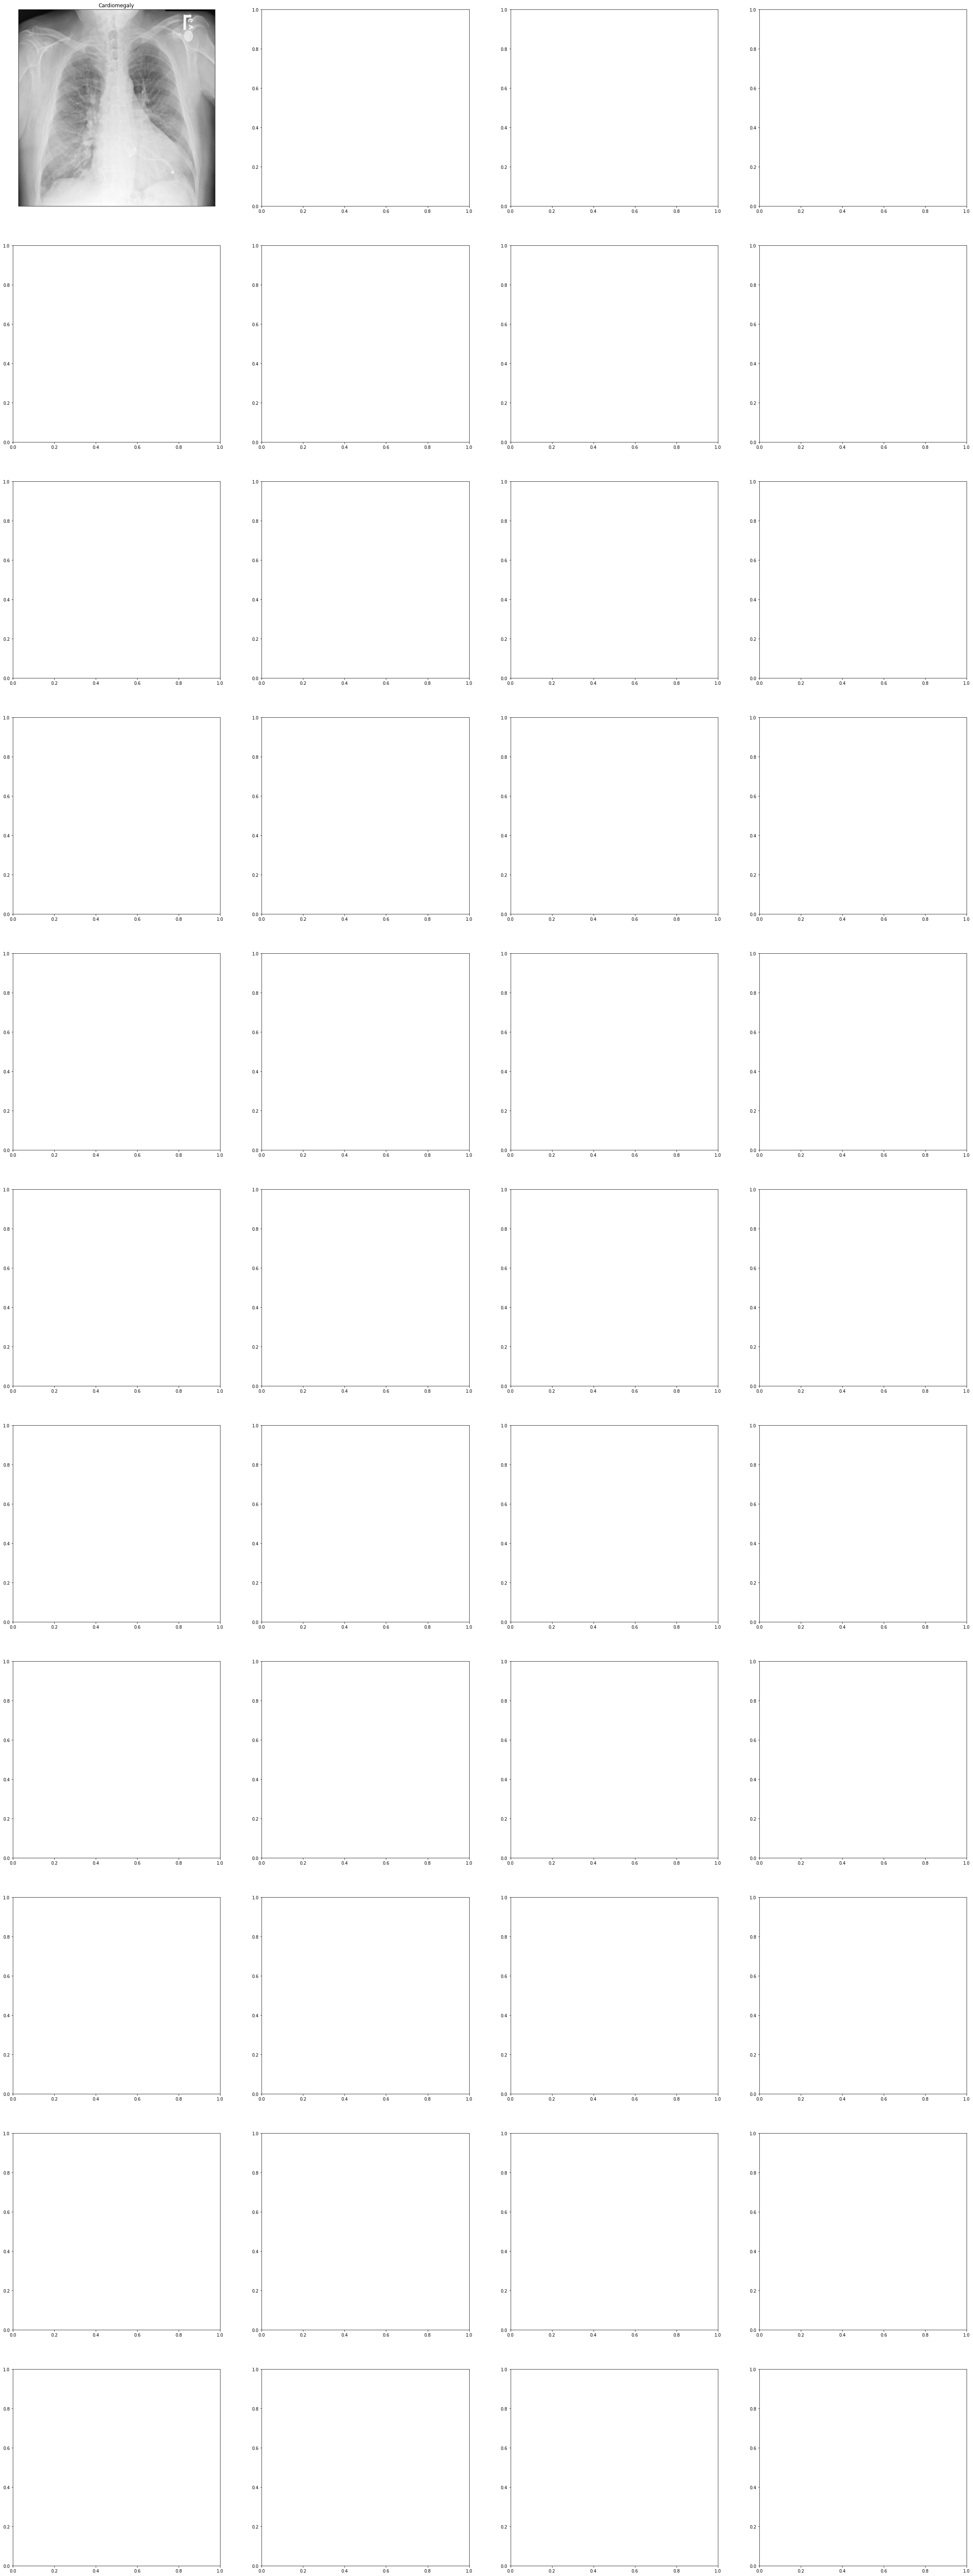

In [ ]:
rows = len(diseases_dict.keys())
cols = 4
fig, ax = plt.subplots(rows, cols, figsize = (10 * cols,10 * rows))
ax = ax.flatten()
i = 0

def process_img(img):
  _img = tf.io.read_file(img)
  _img = tf.image.decode_png(_img,configs['channels'] = configs['channels'])
  # _img = tf.image.resize(_img,IMG_SIZE[:2])
  # _img /= 255 # Just for the efficientNet we dont need this
  return _img[:,:,0]

for name, disease_df in diseases_dict.items():
  for j in range(cols):
    _df = disease_df.sample(frac = 1)
    img = process_img(_df['path'].values[j])
    ax[i].imshow(img, cmap = 'gray')
    ax[i].set_title(name)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel(_df['Finding Label'].values[j])
    plt.tight_layout()
    i += 1
plt.show()

##Finding Correlation

In [ ]:
findings = working_df['findings']

corr_df = pd.DataFrame(index = PATHOLOGY_LIST, columns = PATHOLOGY_LIST)

for i in PATHOLOGY_LIST:
  disease_df = working_df[working_df['findings'].str.contains(i)]
  n = 0
  for j in PATHOLOGY_LIST:
    x = len(disease_df[disease_df['findings'].str.contains(j)])
    corr_df.loc[i,j] = x / len(disease_df) * 100


In [ ]:
plt.figure(figsize = (15,15))
well = np.array(corr_df.values).astype('int')
plt.imshow(well, vmax = 100)
plt.colorbar()
plt.xticks(np.arange(10),PATHOLOGY_LIST, rotation = 90)
plt.yticks(np.arange(10),PATHOLOGY_LIST,)
plt.show()

NameError: ignored